In [2]:
import numpy as np
import random
import gym as gym
import d4rl
from collections import deque
import os
import matplotlib.pyplot as plt

import pickle

/home/ubuntu/miniconda3/envs/mopo_d4rl/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
No module named 'flow'
/home/ubuntu/miniconda3/envs/mopo_d4rl/lib/python3.8/site-packages/glfw/__init__.py:917: GLFWError: (65550) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Jan 29 2025 23:19:57


In [9]:
# env = gym.make('hopper-medium-v2')
# ho_dataset = env.get_dataset()
# with open('/public/d4rl/hopper-medium-v2.pkl', 'wb') as f:
#         pickle.dump(ho_dataset, f)
# env = gym.make('halfcheetah-medium-v2')
# ha_dataset = env.get_dataset()
# with open('/public/d4rl/halfcheetah-medium-v2.pkl', 'wb') as f:
#         pickle.dump(ha_dataset, f)
env = gym.make('walker2d-medium-expert-v2')
wa_dataset = env.get_dataset()

env = gym.make('halfcheetah-medium-expert-v2')
ha_dataset = env.get_dataset()

# env = gym.make('hopper-medium-expert-v2')
# ho_dataset = env.get_dataset()

# with open('/public/d4rl/walker2d-medium-v2.pkl', 'wb') as f:
#         pickle.dump(wa_dataset, f)
# env = gym.make('halfcheetah-medium-v2')
# ha_dataset = env.get_dataset()

load datafile: 100%|██████████| 9/9 [01:30<00:00, 10.01s/it]


In [10]:
import numpy as np
import random

def select_subset_and_add_noise(
    dataset,
    num_trajectories=50,
    noise_std=0.1,
    noise_mean=0.0,
    num_samples=10000,
    use_timeouts=True,
    clip_actions=False,
    action_low=-1.0,
    action_high=1.0,
    seed=None,
):
    rng = np.random.default_rng(seed)

    obs = dataset["next_observations"]
    acts = dataset["actions"]
    rews = dataset["rewards"]
    terms = dataset.get("terminals", np.zeros(len(rews), dtype=bool))

    if use_timeouts and ("timeouts" in dataset):
        ends = np.logical_or(terms.astype(bool), dataset["timeouts"].astype(bool))
    else:
        ends = terms.astype(bool)

    # Build (start, end) episode index ranges
    traj_indices = []
    start = 0
    for i, done in enumerate(ends):
        if done:
            traj_indices.append((start, i + 1))
            start = i + 1

    # Fallback: if no episode boundaries exist, just slice first num_samples transitions
    if len(traj_indices) == 0:
        idx = slice(0, min(num_samples, len(rews)))
        traj_obs = obs[idx]
        traj_acts = acts[idx]
        traj_rews = rews[idx]
        traj_ends = ends[idx]

        noise_obs = rng.uniform(loc=noise_mean, scale=noise_std, size=traj_obs.shape)
        noise_act = rng.uniform(loc=noise_mean, scale=noise_std, size=traj_acts.shape)

        # noise_obs = noise_mean*np.ones(traj_obs.shape) 
        
        # noise_act = noise_mean*np.ones(traj_acts.shape)



        new_obs = traj_obs + noise_obs
        new_acts = traj_acts + noise_act

        if clip_actions:
            new_acts = np.clip(new_acts, action_low, action_high)

        new_dataset = dict(observations=new_obs, actions=new_acts, rewards=traj_rews, terminals=traj_ends)
        orig_dataset = dict(observations=traj_obs, actions=traj_acts, rewards=traj_rews, terminals=traj_ends)
        return new_dataset, orig_dataset

    # Sample trajectories
    k = min(num_trajectories, len(traj_indices))
    selected = random.sample(traj_indices, k)

    new_obs_list, new_act_list, new_rew_list, new_end_list = [], [], [], []
    old_obs_list, old_act_list = [], []

    for s, e in selected:
        traj_obs = obs[s:e]
        traj_acts = acts[s:e]
        traj_rews = rews[s:e]
        traj_ends = ends[s:e]

        noise_obs = rng.normal(loc=noise_mean, scale=noise_std, size=traj_obs.shape)
        noise_act = rng.normal(loc=noise_mean, scale=noise_std, size=traj_acts.shape)
        # noise_obs = noise_mean*np.ones(traj_obs.shape) 
        
        # noise_act = noise_mean*np.ones(traj_acts.shape)
        traj_obs_noisy = traj_obs + noise_obs
        traj_acts_noisy = traj_acts + noise_act

        if clip_actions:
            traj_acts_noisy = np.clip(traj_acts_noisy, action_low, action_high)

        new_obs_list.append(traj_obs_noisy)
        new_act_list.append(traj_acts_noisy)
        new_rew_list.append(traj_rews)
        new_end_list.append(traj_ends)
        old_obs_list.append(traj_obs)
        old_act_list.append(traj_acts)

    new_dataset = {

        "observations": np.concatenate(new_obs_list, axis=0),
        "actions": np.concatenate(new_act_list, axis=0),
        "rewards": np.concatenate(new_rew_list, axis=0),
        "terminals": np.concatenate(new_end_list, axis=0),
    }
    orig_dataset = {
        "observations": np.concatenate(old_obs_list, axis=0),
        "actions": np.concatenate(old_act_list, axis=0),
        "rewards": new_dataset["rewards"],
        "terminals": new_dataset["terminals"],
    }
    return new_dataset, orig_dataset


In [11]:
#concatenate ood_data_5 and normal and save in /public/d4rl/ood_test/walker2d-medium-v2/-ood-distance-5.pkl
def save_combined_dataset(normal, ood_data, d_name, distance):
    
    combined_data = {
        'observations': np.concatenate([normal['observations'], ood_data['observations']]),
        'actions': np.concatenate([normal['actions'], ood_data['actions']]),
        'rewards': np.concatenate([normal['rewards'], ood_data['rewards']]),
        'terminals': np.concatenate([normal['terminals'], ood_data['terminals']])
    }
    os.makedirs(f'/public/d4rl/ood_test/{d_name}/', exist_ok=True)
    with open(f'/public/d4rl/ood_test/{d_name}/ood-distance-{str(distance)}.pkl', 'wb') as f:
        pickle.dump(combined_data, f)




In [12]:
# ood_data_4, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 4)
# combined_4 = {
#     'observations': np.concatenate([normal['observations'], ood_data_4['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_4['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_4['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_4['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-4-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_4, f)

# ood_data_3, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 3)
# combined_3 = {
#     'observations': np.concatenate([normal['observations'], ood_data_3['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_3['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_3['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_3['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-3-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_3, f)

# ood_data_2, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 2)
# combined_2 = {
#     'observations': np.concatenate([normal['observations'], ood_data_2['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_2['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_2['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_2['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-2-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_2, f)


ood_data_1, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
combined_1 = {
    'observations': np.concatenate([normal['observations'], ood_data_1['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_1['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_1['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_1['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-1-uniform.pkl', 'wb') as f:
    pickle.dump(combined_1, f)

ood_data_08, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.8)
combined_08 = {
    'observations': np.concatenate([normal['observations'], ood_data_08['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_08['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_08['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_08['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-0.8-uniform.pkl', 'wb') as f:
    pickle.dump(combined_08, f)


# ood_data_05, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.5)
# combined_05 = {
#     'observations': np.concatenate([normal['observations'], ood_data_05['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_05['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_05['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_05['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-0.5-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_08, f)

ood_data_06, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.6)
combined_06 = {
    'observations': np.concatenate([normal['observations'], ood_data_06['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_06['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_06['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_06['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-0.6-uniform.pkl', 'wb') as f:
    pickle.dump(combined_06, f)

ood_data_04, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.4)
combined_04 = {
    'observations': np.concatenate([normal['observations'], ood_data_04['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_04['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_04['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_04['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-0.4-uniform.pkl', 'wb') as f:
    pickle.dump(combined_04, f)

In [8]:
# ood_data_3, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 3)
# combined_3 = {
#     'observations': np.concatenate([normal['observations'], ood_data_3['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_3['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_3['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_3['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-3-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_3, f)


# ood_data_2, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 2)
# combined_2 = {
#     'observations': np.concatenate([normal['observations'], ood_data_2['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_2['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_2['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_2['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-2-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_2, f)

ood_data_18, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.8)
combined_18 = {
    'observations': np.concatenate([normal['observations'], ood_data_18['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_18['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_18['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_18['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.8-uniform.pkl', 'wb') as f:
    pickle.dump(combined_18, f)


ood_data_16, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.6)
combined_16 = {
    'observations': np.concatenate([normal['observations'], ood_data_16['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_16['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_16['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_16['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.6-uniform.pkl', 'wb') as f:
    pickle.dump(combined_16, f)


ood_data_14, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.4)
combined_14 = {
    'observations': np.concatenate([normal['observations'], ood_data_14['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_14['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_14['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_14['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.4-uniform.pkl', 'wb') as f:
    pickle.dump(combined_14, f)

ood_data_12, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.2)
combined_12 = {
    'observations': np.concatenate([normal['observations'], ood_data_12['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_12['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_12['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_12['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.2-uniform.pkl', 'wb') as f:
    pickle.dump(combined_12, f)

ood_data_1, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
combined_1 = {
    'observations': np.concatenate([normal['observations'], ood_data_1['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_1['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_1['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_1['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1-uniform.pkl', 'wb') as f:
    pickle.dump(combined_1, f)

# ood_data_08, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.8)
# combined_08 = {
#     'observations': np.concatenate([normal['observations'], ood_data_08['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_08['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_08['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_08['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-0.8-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_08, f)
# ood_data_06, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.6)
# combined_06 = {
#     'observations': np.concatenate([normal['observations'], ood_data_06['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_06['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_06['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_06['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-0.6-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_06, f)
# ood_data_04, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.4)
# combined_04 = {
#     'observations': np.concatenate([normal['observations'], ood_data_04['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_04['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_04['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_04['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/hopper-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-0.4-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_04, f)

In [13]:
# ood_data_4, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 4)
# combined_4 = {
#     'observations': np.concatenate([normal['observations'], ood_data_4['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_4['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_4['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_4['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-4-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_4, f)

# ood_data_3, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 3)
# combined_3 = {
#     'observations': np.concatenate([normal['observations'], ood_data_3['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_3['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_3['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_3['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-3-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_3, f)

# ood_data_2, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 2)
# combined_2 = {
#     'observations': np.concatenate([normal['observations'], ood_data_2['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_2['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_2['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_2['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-2-uniform.pkl', 'wb') as f:
#     pickle.dump(combined_2, f)

# ood_data_16, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.6)
# combined_16 = {
#     'observations': np.concatenate([normal['observations'], ood_data_16['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_16['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_16['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_16['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-1.6-uniform.pkl', 'wb') as f:
#     pickle.dump(ood_data_16, f)

# ood_data_14, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.4)
# combined_14 = {
#     'observations': np.concatenate([normal['observations'], ood_data_14['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_14['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_14['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_14['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-1.4-uniform.pkl', 'wb') as f:
#     pickle.dump(ood_data_14, f)


# ood_data_12, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1.2)
# combined_12 = {
#     'observations': np.concatenate([normal['observations'], ood_data_12['observations']]),
#     'actions': np.concatenate([normal['actions'], ood_data_12['actions']]),
#     'rewards': np.concatenate([normal['rewards'], ood_data_12['rewards']]),
#     'terminals': np.concatenate([normal['terminals'], ood_data_12['terminals']])
# }
# os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
# with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-1.2-uniform.pkl', 'wb') as f:
#     pickle.dump(ood_data_12, f)

ood_data_1, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = -1)
combined_1 = {
    'observations': np.concatenate([normal['observations'], ood_data_1['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_1['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_1['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_1['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-1-uniform.pkl', 'wb') as f:
    pickle.dump(combined_1, f)

ood_data_08, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = -0.8)
combined_08 = {
    'observations': np.concatenate([normal['observations'], ood_data_08['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_08['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_08['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_08['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-0.8-uniform.pkl', 'wb') as f:
    pickle.dump(combined_08, f)
ood_data_06, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = -0.6)
combined_06 = {
    'observations': np.concatenate([normal['observations'], ood_data_06['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_06['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_06['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_06['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-0.6-uniform.pkl', 'wb') as f:
    pickle.dump(combined_06, f)
ood_data_04, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = -0.4)
combined_04 = {
    'observations': np.concatenate([normal['observations'], ood_data_04['observations']]),
    'actions': np.concatenate([normal['actions'], ood_data_04['actions']]),
    'rewards': np.concatenate([normal['rewards'], ood_data_04['rewards']]),
    'terminals': np.concatenate([normal['terminals'], ood_data_04['terminals']])
}
os.makedirs(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/', exist_ok=True)
with open(f'/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-0.4-uniform.pkl', 'wb') as f:
    pickle.dump(combined_04, f)


In [9]:
def plot_contour_action_norm_vs_reward(dataset, title="Action Norm vs Reward Contour",                                                                 
                                               bins=20, unsafe_region_reward=None,                                                                            
                                               unsafe_region_norm=None, cmap='viridis', ax=None,                                                              
                                               show_colorbar=True, show_ylabel=True):                                                                         
           """                                                                                                                                                
           Create a contour plot showing the density of action norm vs reward samples.                                                                        
                                                                                                                                                              
           Args:                                                                                                                                              
               dataset: Dataset dictionary with 'rewards' and 'actions' keys                                                                                  
               title: Title for the plot                                                                                                                      
               bins: Number of bins for the 2D histogram (default: 50)                                                                                        
               unsafe_region_reward: Tuple (min, max) for unsafe reward range (optional)                                                                      
               unsafe_region_norm: Tuple (min, max) for unsafe action norm range (optional)                                                                   
               cmap: Colormap for the contour plot (default: 'viridis')                                                                                       
               ax: Optional matplotlib axis to plot on (for subplots)                                                                                         
               show_colorbar: Whether to show colorbar (default: True)                                                                                        
               show_ylabel: Whether to show y-axis label (default: True)                                                                                      
           """                                                                                                                                                
           # Compute action norms                                                                                                                             
           actions = dataset['actions']                                                                                                                       
           action_norms = np.linalg.norm(actions, axis=1)                                                                                                     
           state_norms = np.linalg.norm(dataset['observations'], axis=1)                                                                                      
           # rewards = dataset['rewards']                                                                                                                     
                                                                                                                                                              
           # Create figure/axis if not provided                                                                                                               
           if ax is None:                                                                                                                                     
               fig, ax = plt.subplots(figsize=(8, 5), dpi=300)                                                                                                         
               standalone = True                                                                                                                              
           else:                                                                                                                                              
               fig = ax.get_figure()                                                                                                                          
               standalone = False                                                                                                                             
                                                                                                                                                              
           # Add padding to the range to avoid cutting off the distribution                                                                                   
           norm_range = action_norms.max() - action_norms.min()                                                                                               
           reward_range = state_norms.max() - state_norms.min()                                                                                               
           norm_padding = norm_range * 0.1  # 10% padding                                                                                                     
           reward_padding = reward_range * 0.1  # 10% padding                                                                                                 
                                                                                                                                                              
           # Compute histogram with extended range                                                                                                            
           hist, xedges, yedges = np.histogram2d(                                                                                                             
               action_norms, state_norms, bins=bins,                                                                                                          
               range=[[action_norms.min() - norm_padding, action_norms.max() + norm_padding],                                                                 
                      [state_norms.min() - reward_padding, state_norms.max() + reward_padding]]                                                               
           )                                                                                                                                                  
                                                                                                                                                              
           # Create meshgrid for contour plot                                                                                                                 
           X, Y = np.meshgrid(xedges[:-1], yedges[:-1])                                                                                                       
                                                                                                                                                              
           # Create filled contour plot                                                                                                                       
           contour = ax.contourf(X, Y, hist.T, levels=20, cmap=cmap, alpha=0.8)                                                                               
                                                                                                                                                              
           # Add contour lines                                                                                                                                
           contour_lines = ax.contour(X, Y, hist.T, levels=10, colors='black', alpha=0.3, linewidths=0.5)                                                     
                                                                                                                                                              
           # Add colorbar only if requested                                                                                                                   
           if show_colorbar:                                                                                                                                  
               cbar = plt.colorbar(contour, ax=ax, label='Sample Density')                                                                                    
                                                                                                                                                              
           # Highlight unsafe region if provided                                                                                                              
           if unsafe_region_reward is not None and unsafe_region_norm is not None:                                                                            
               from matplotlib.patches import Rectangle                                                                                                       
               rect = Rectangle((unsafe_region_norm[0], unsafe_region_reward[0]),                                                                             
                                unsafe_region_norm[1] - unsafe_region_norm[0],                                                                                
                                unsafe_region_reward[1] - unsafe_region_reward[0],                                                                            
                                linewidth=2, edgecolor='red', facecolor='none',                                                                               
                                linestyle='--', label='Unsafe Region')                                                                                        
               ax.add_patch(rect)                                                                                                                             
               ax.legend(fontsize=10)                                                                                                                         
                                                                                                                                                              
           ax.set_xlabel('Action L2 Norm', fontsize=12)                                                                                                       
           if show_ylabel:                                                                                                                                    
               ax.set_ylabel('State L2 Norm', fontsize=12)                                                                                                    
           ax.set_title(title, fontsize=14)                                                                                                                   
           ax.grid(True, alpha=0.3)                                                                                                                           
                                                                                                                                                              
           if standalone:                                                                                                                                     
               plt.tight_layout()                                                                                                                             
               plt.show()                                                                                                                                     
                                                                                                                                                              
           return fig, contour                                                                                                                                
                                                                                                                                                              
                                                                                                                                                        
def plot_contour_side_by_side(datasets, titles, bins=50, cmap='viridis', figsize=(18, 5)):                                                             
    """                                                                                                                                                
    Plot multiple contour plots side by side in one row.                                                                                               
                                                                                                                                                        
    Args:                                                                                                                                              
        datasets: List of dataset dictionaries                                                                                                         
        titles: List of titles for each plot                                                                                                           
        bins: Number of bins for the 2D histogram                                                                                                      
        cmap: Colormap for the contour plots                                                                                                           
        figsize: Figure size (width, height)                                                                                                           
    """                                                                                                                                                
    n_plots = len(datasets)                                                                                                                            
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)                                                                                              
                                                                                                                                                        
    if n_plots == 1:                                                                                                                                   
        axes = [axes]                                                                                                                                  
                                                                                                                                                        
    last_contour = None                                                                                                                                
    for i, (ax, dataset, title) in enumerate(zip(axes, datasets, titles)):                                                                             
        # Only show y-label on the leftmost plot                                                                                                       
        show_ylabel = (i == 0)                                                                                                                         
                                                                                                                                                        
        _, contour = plot_contour_action_norm_vs_reward(                                                                                               
            dataset,                                                                                                                                   
            title=title,                                                                                                                               
            bins=bins,                                                                                                                                 
            cmap=cmap,                                                                                                                                 
            ax=ax,                                                                                                                                     
            show_colorbar=False,  # Don't show individual colorbars                                                                                    
            show_ylabel=show_ylabel                                                                                                                    
        )                                                                                                                                              
        last_contour = contour                                                                                                                         
                                                                                                                                                        
    # Adjust spacing: reduce space between plots, leave room for colorbar                                                                              
    fig.subplots_adjust(left=0.06, right=0.92, wspace=0.1)                                                                                            
                                                                                                                                                        
    # Add a single thin colorbar on the right side of the figure                                                                                       
    cbar_ax = fig.add_axes([0.94, 0.15, 0.012, 0.7])                                                                                                   
    fig.colorbar(last_contour, cax=cbar_ax, label='Sample Density')                                                                                    
                                                                                                                                                        
    plt.show()                                                                                                                                         
    return fig                                                                                                                                         
                

In [ ]:
# Load datasets for all three environments
env_hopper = gym.make('hopper-medium-v2')
hopper_dataset = env_hopper.get_dataset()

env_halfcheetah = gym.make('halfcheetah-medium-v2')
halfcheetah_dataset = env_halfcheetah.get_dataset()

env_walker2d = gym.make('walker2d-medium-v2')
walker2d_dataset = env_walker2d.get_dataset()



In [13]:

with open('/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1-uniform.pkl', 'rb') as f:
    combined_1 = pickle.load(f)

with open('/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.2-uniform.pkl', 'rb') as f:
    combined_12 = pickle.load(f)

with open('/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.4-uniform.pkl', 'rb') as f:
    combined_14 = pickle.load(f)

with open('/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.6-uniform.pkl', 'rb') as f:
    combined_16 = pickle.load(f)

with open('/public/d4rl/ood_test/hopper-medium-expert-v2/ood-distance-1.8-uniform.pkl', 'rb') as f:
    combined_18 = pickle.load(f)

In [24]:
with open('/public/d4rl/ood_test/halfcheetah-medium-expert-v2/ood-distance-1-uniform.pkl', 'rb') as f:
    combined_1_ha = pickle.load(f)

with open('/public/d4rl/ood_test/walker2d-medium-expert-v2/ood-distance-1-uniform.pkl', 'rb') as f:
    combined_1_wa = pickle.load(f)

In [3]:
with open('/public/gormpo/ood_test/ood-distance-noise_std_1.pkl', 'rb') as f:
    ood_distance_1 = pickle.load(f)

with open('/public/gormpo/ood_test/ood-distance-noise_std_2.pkl', 'rb') as f:
    ood_distance_2 = pickle.load(f)
with open('/public/gormpo/ood_test/ood-distance-noise_std_3.pkl', 'rb') as f:
    ood_distance_3 = pickle.load(f)
with open('/public/gormpo/ood_test/ood-distance-noise_std_4.pkl', 'rb') as f:
    ood_distance_4 = pickle.load(f)

In [25]:
print(len(ood_distance_4['observations']),
len(combined_14['observations']),
len(combined_1_ha['observations']),
len(combined_1_wa['observations']))

400 7992 10000 9546


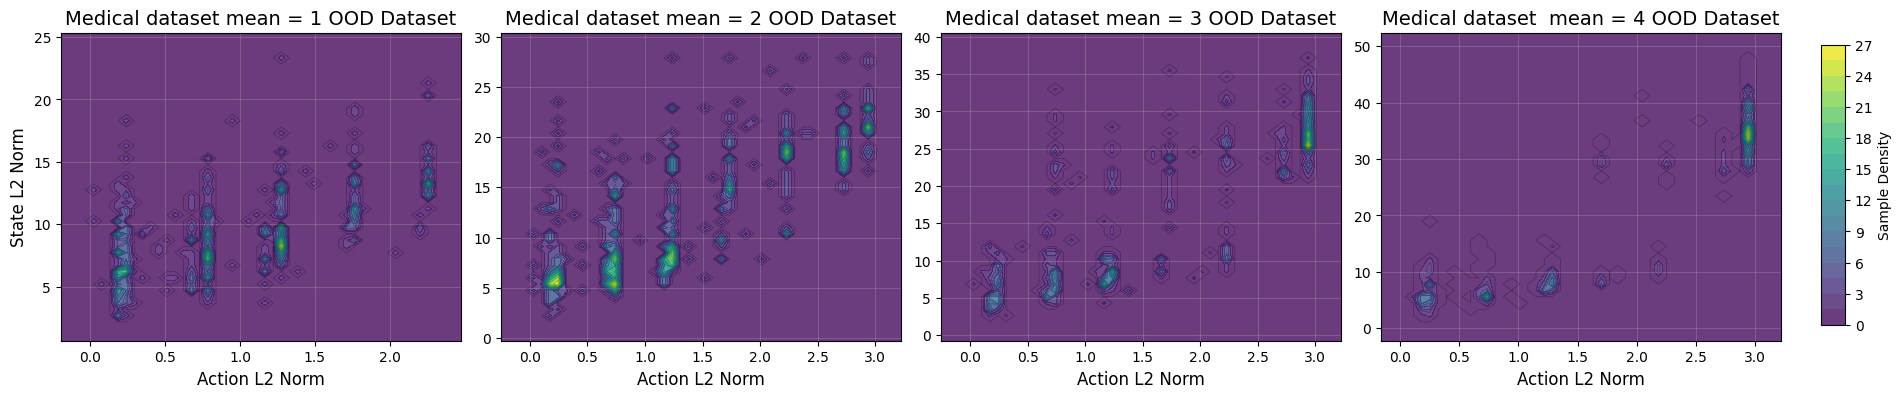

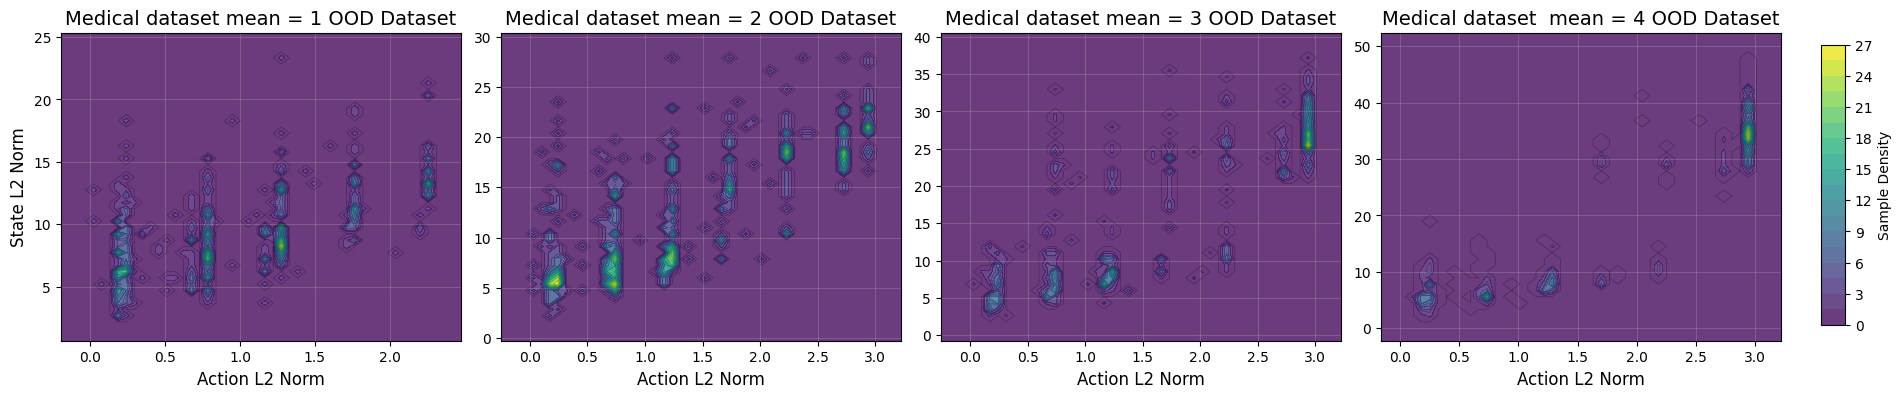

In [4]:
plot_contour_side_by_side(
    datasets=[ood_distance_1, ood_distance_2, ood_distance_3, ood_distance_4],
    titles=['Medical dataset mean = 1 OOD Dataset',
             'Medical dataset mean = 2 OOD Dataset',
               'Medical dataset mean = 3 OOD Dataset',
               'Medical dataset  mean = 4 OOD Dataset',
],
    bins=50,
    cmap='viridis',
    figsize=(20, 4)
)

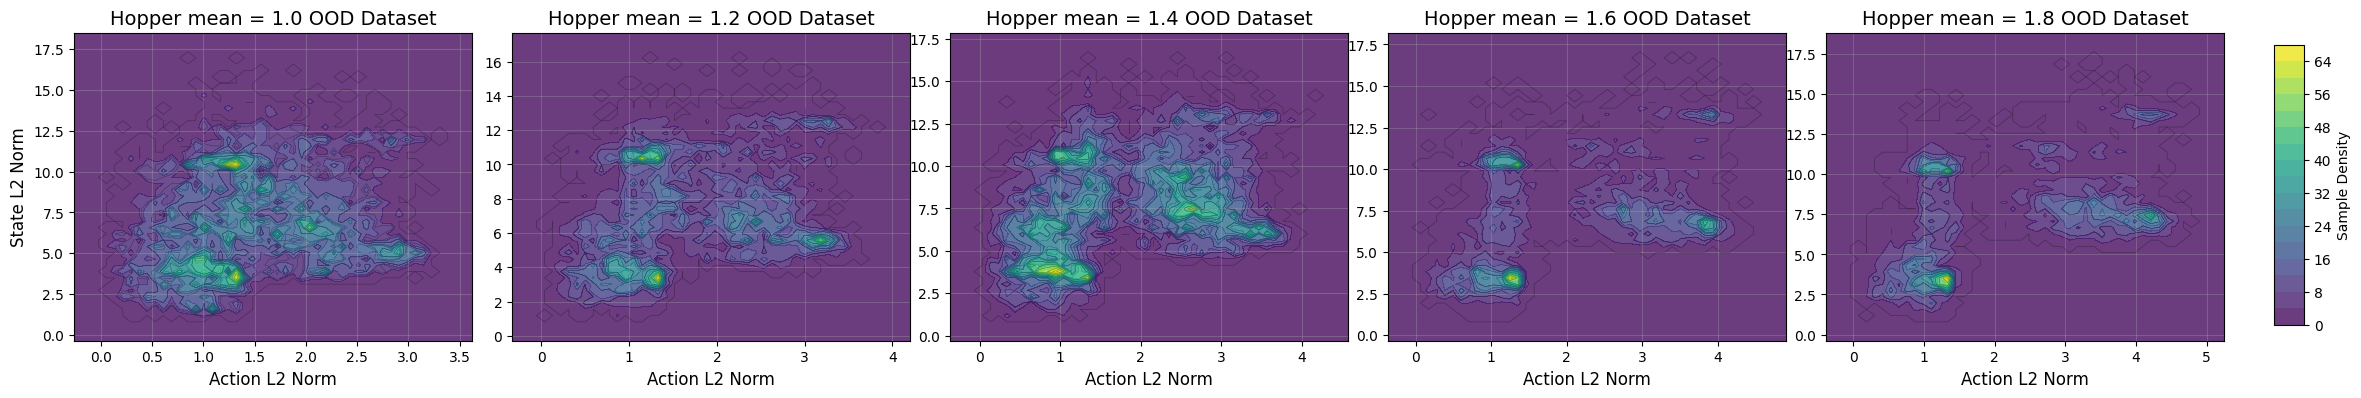

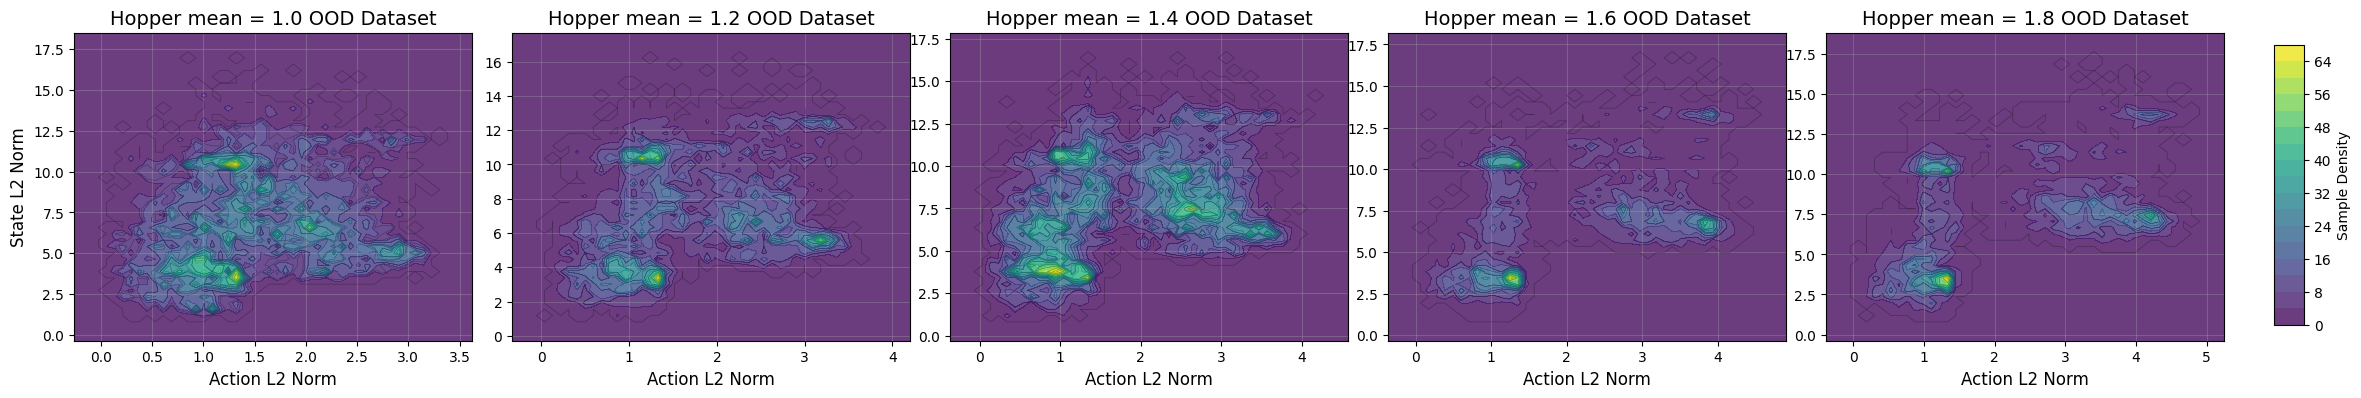

In [14]:
# Plot all three environments side by side
plot_contour_side_by_side(
    datasets=[combined_1, combined_12, combined_14, combined_16, combined_18],
    titles=['Hopper mean = 1.0 OOD Dataset',
             'Hopper mean = 1.2 OOD Dataset',
               'Hopper mean = 1.4 OOD Dataset',
               'Hopper mean = 1.6 OOD Dataset',
               'Hopper mean = 1.8 OOD Dataset'],
    bins=50,
    cmap='viridis',
    figsize=(25, 4)
)

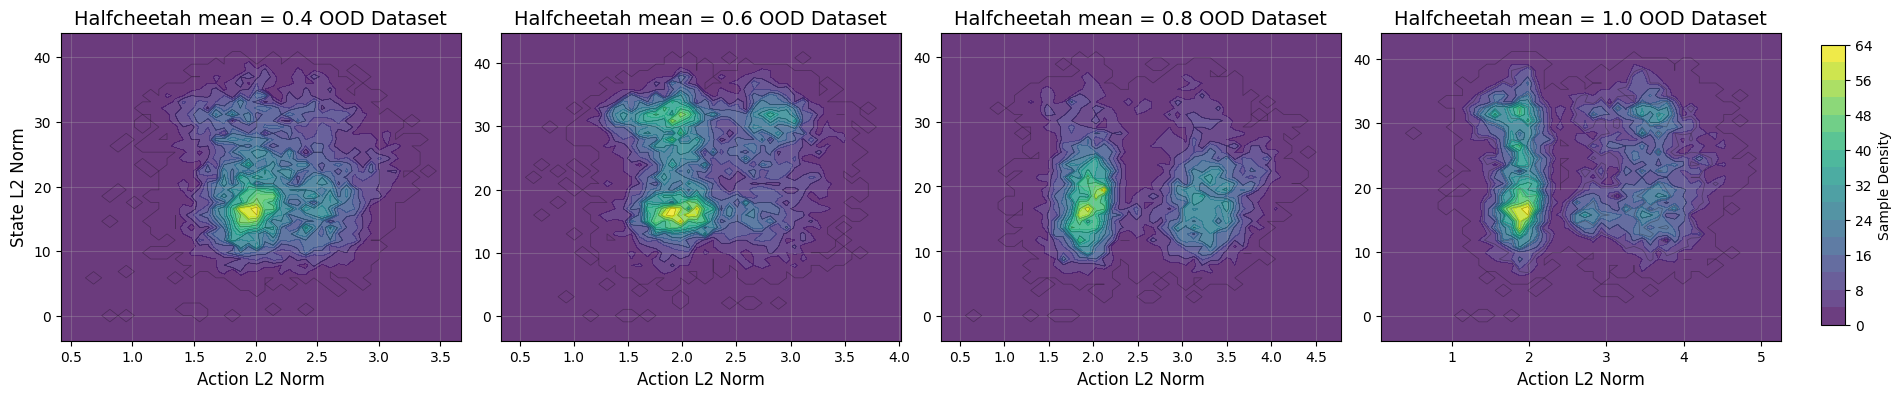

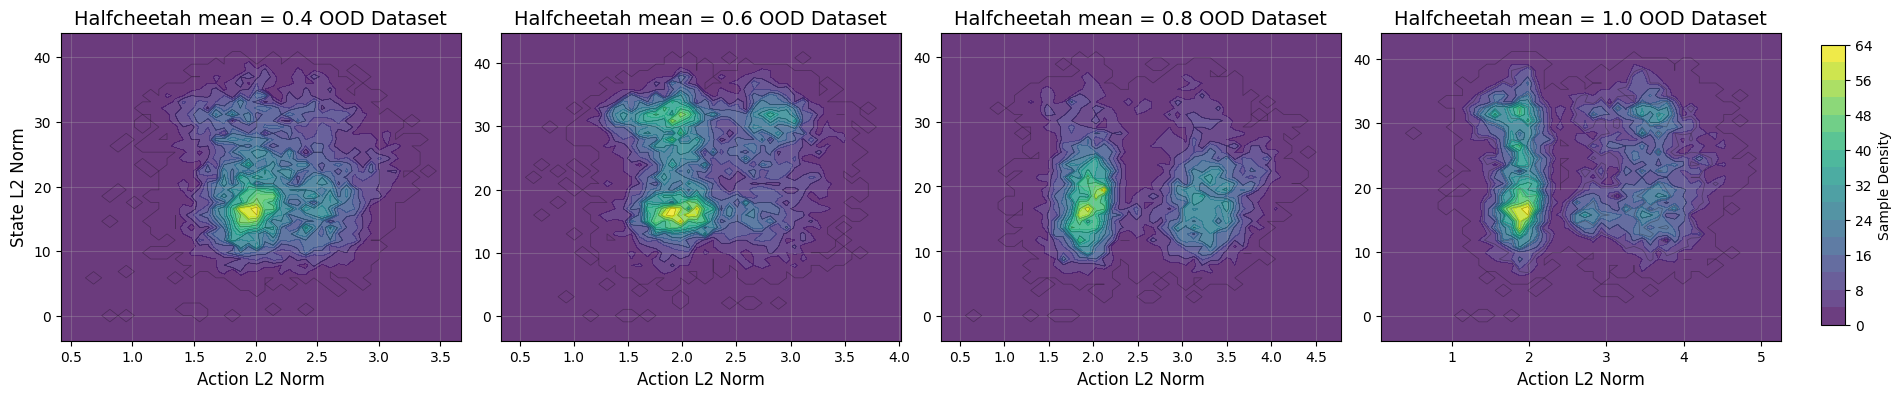

In [38]:
plot_contour_side_by_side(
    datasets=[combined_04, combined_06, combined_08, combined_1],
    titles=[
             'Halfcheetah mean = 0.4 OOD Dataset',
               'Halfcheetah mean = 0.6 OOD Dataset',
               'Halfcheetah mean = 0.8 OOD Dataset',
               'Halfcheetah mean = 1.0 OOD Dataset'],
    bins=50,
    cmap='viridis',
    figsize=(20, 4)
)

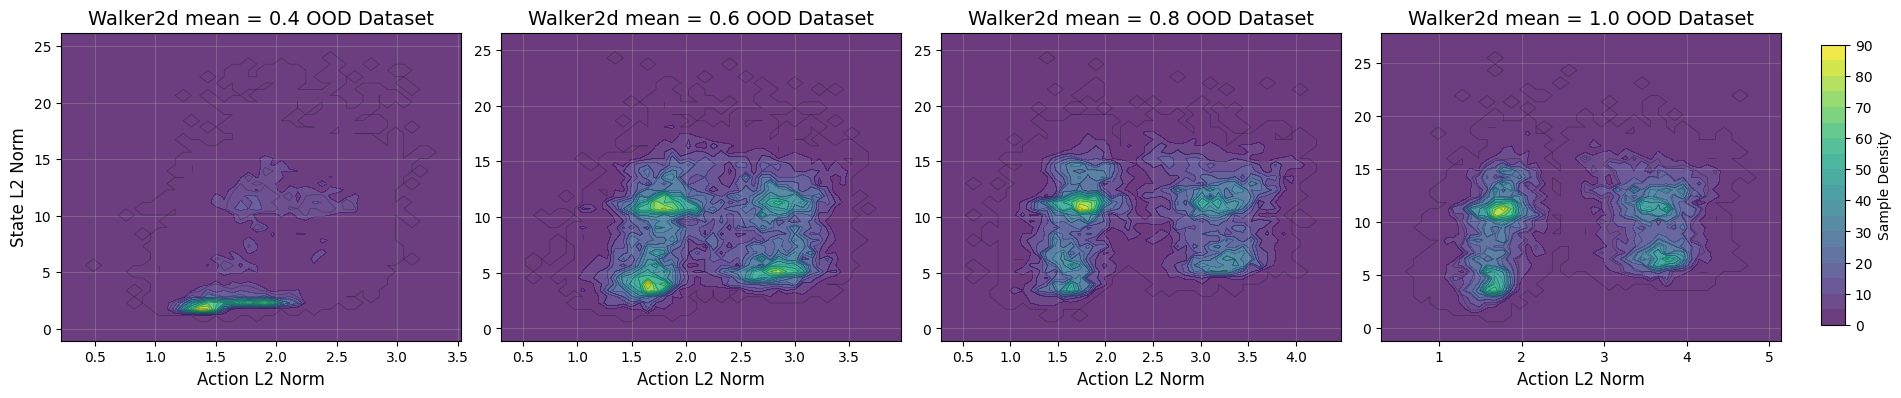

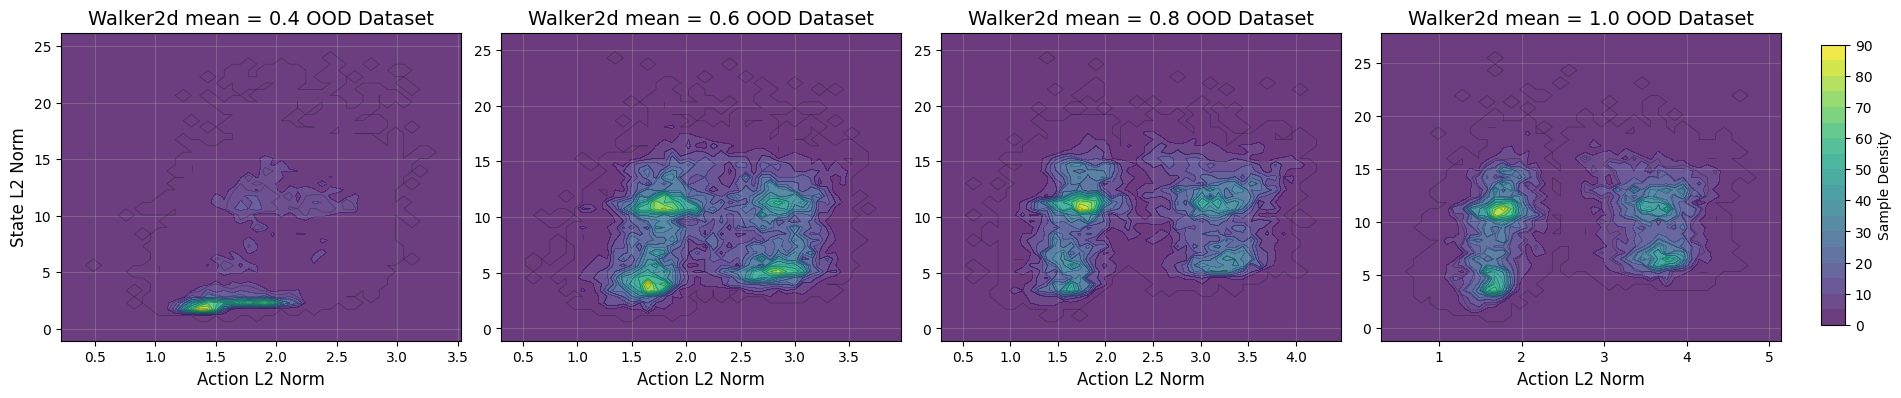

In [43]:
plot_contour_side_by_side(
    datasets=[combined_04, combined_06, combined_08, combined_1],
    titles=[
             'Walker2d mean = 0.4 OOD Dataset',
               'Walker2d mean = 0.6 OOD Dataset',
               'Walker2d mean = 0.8 OOD Dataset',
               'Walker2d mean = 1.0 OOD Dataset'],
    bins=50,
    cmap='viridis',
    figsize=(20, 4)
)

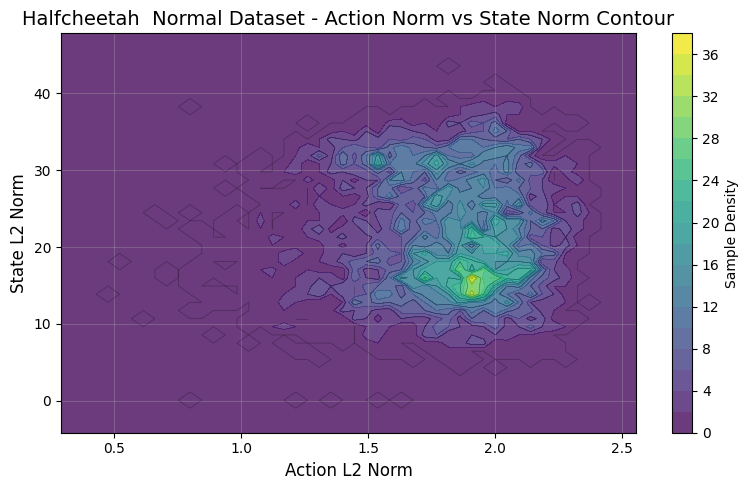

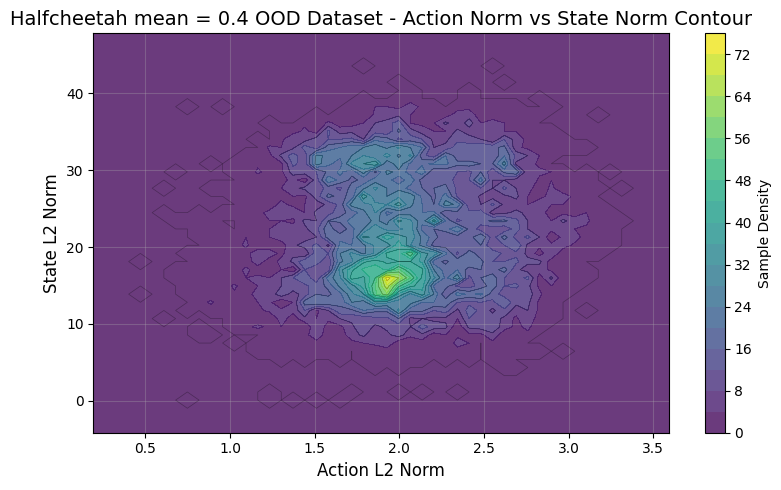

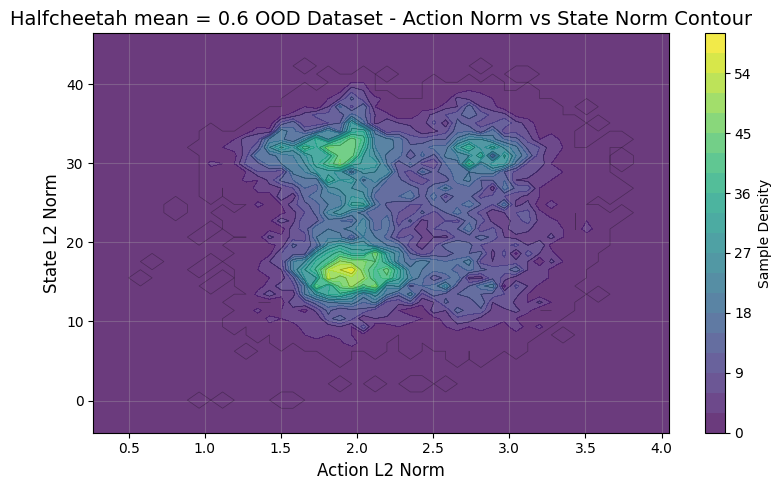

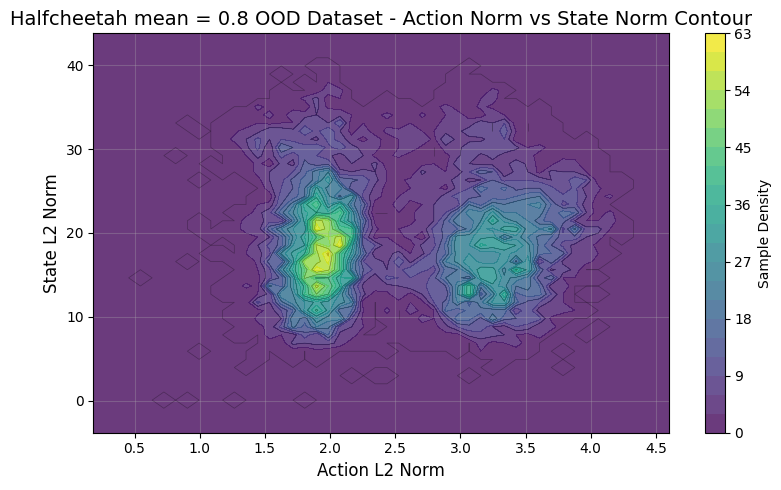

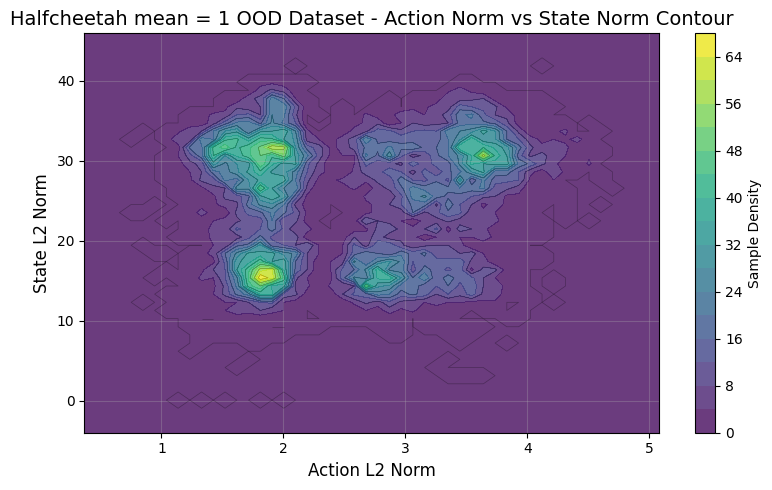

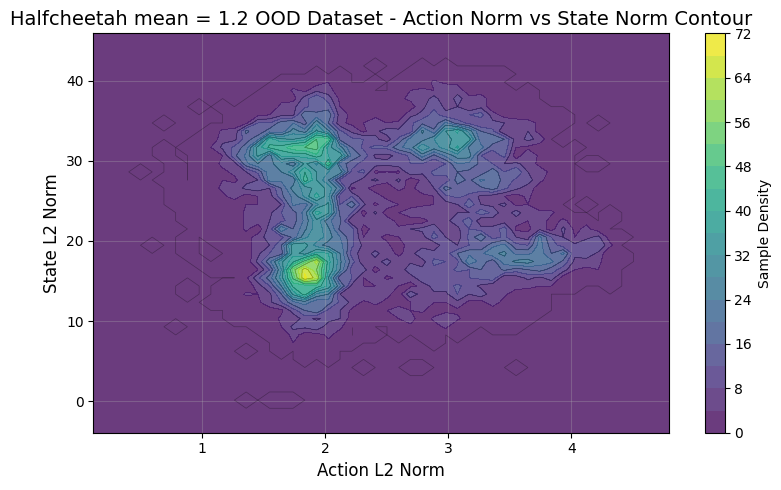

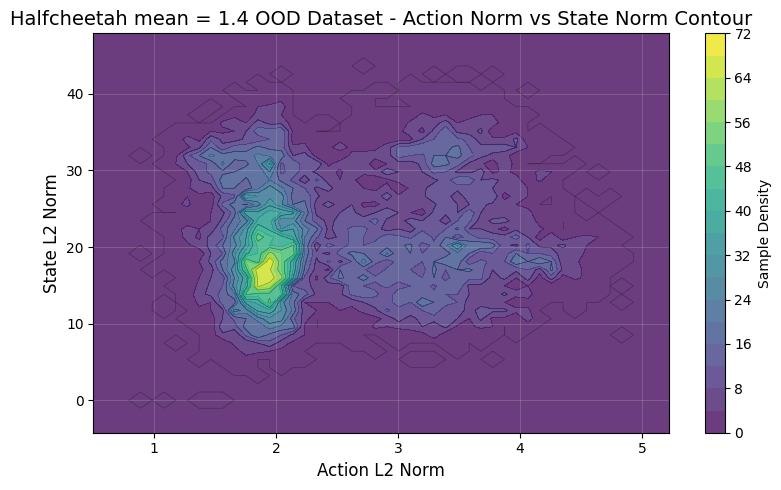

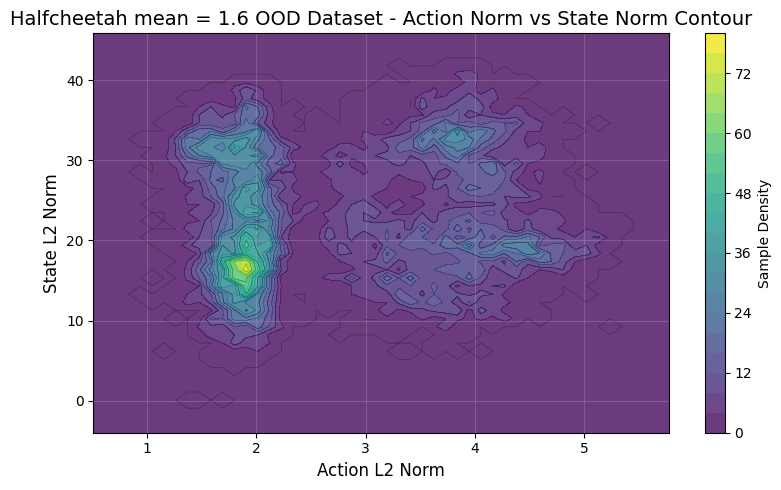

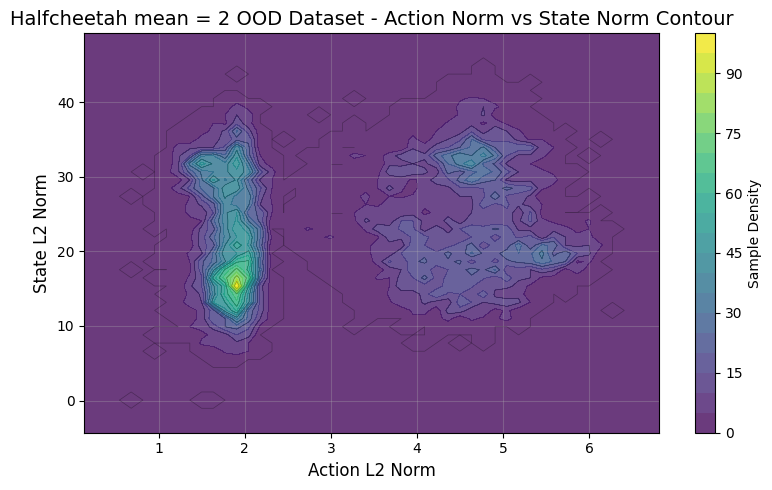

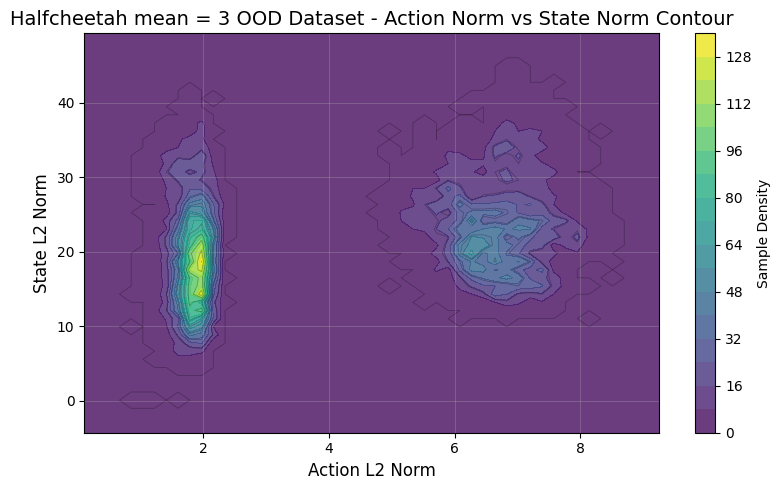

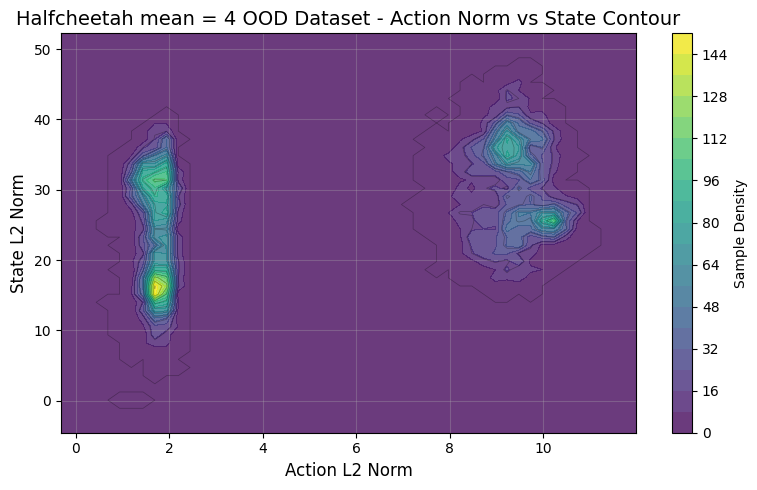

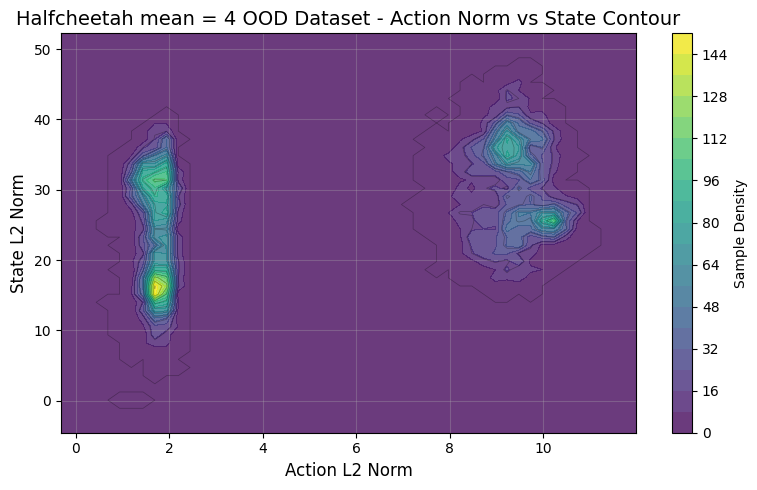

In [95]:
plot_contour_action_norm_vs_reward(
        normal, 
        title=f"Halfcheetah  Normal Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_04, 
        title=f"Halfcheetah mean = 0.4 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_06, 
        title=f"Halfcheetah mean = 0.6 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
    
plot_contour_action_norm_vs_reward(
        combined_08, 
        title=f"Halfcheetah mean = 0.8 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_1, 
        title=f"Halfcheetah mean = 1 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

plot_contour_action_norm_vs_reward(
        combined_12, 
        title=f"Halfcheetah mean = 1.2 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

plot_contour_action_norm_vs_reward(
        combined_14, 
        title=f"Halfcheetah mean = 1.4 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

plot_contour_action_norm_vs_reward(
        combined_16, 
        title=f"Halfcheetah mean = 1.6 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_2, 
        title=f"Halfcheetah mean = 2 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_3, 
        title=f"Halfcheetah mean = 3 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_4, 
        title=f"Halfcheetah mean = 4 OOD Dataset - Action Norm vs State Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

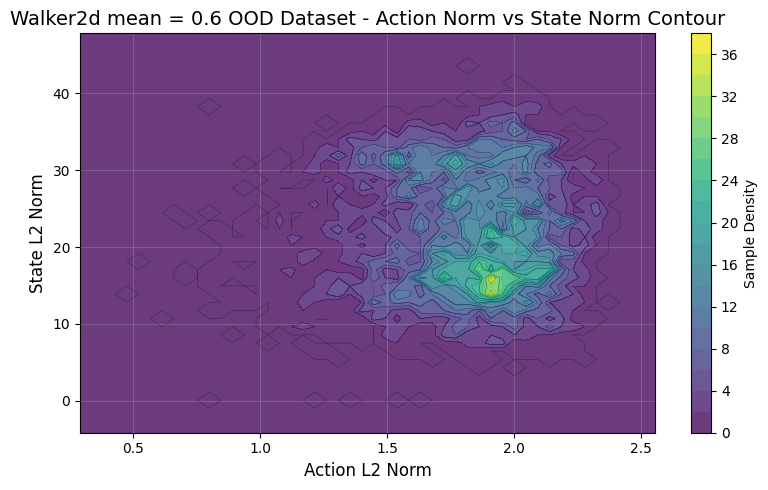

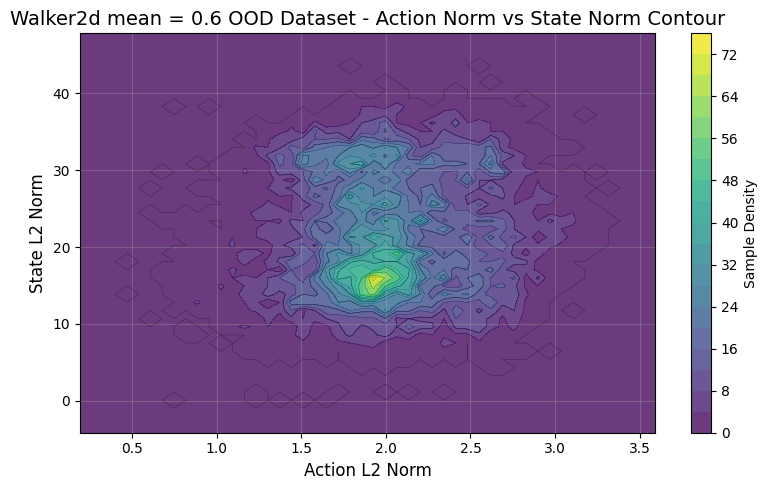

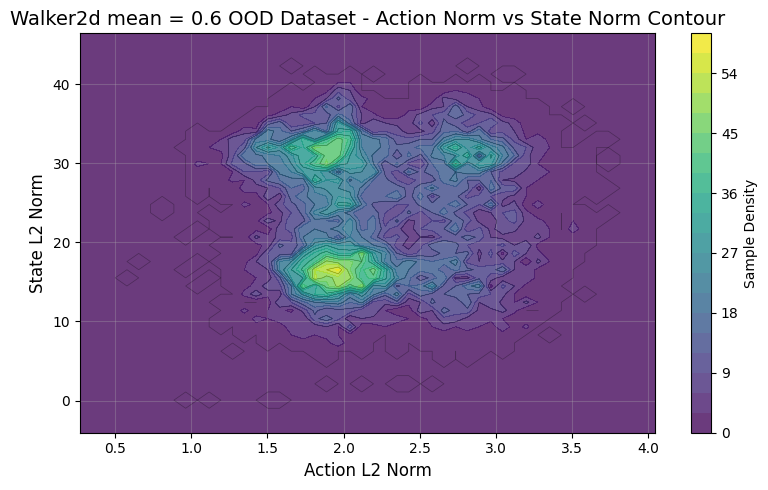

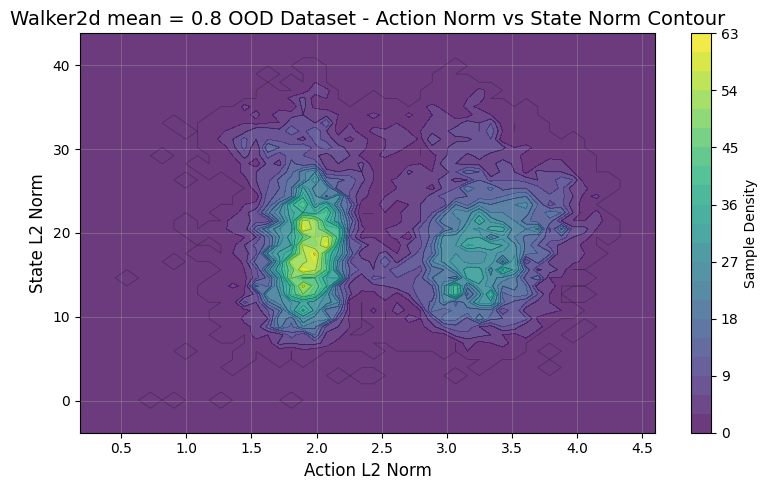

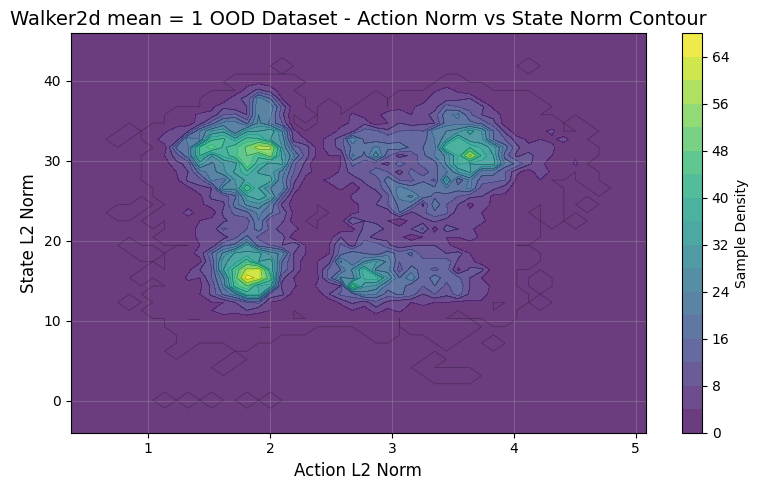

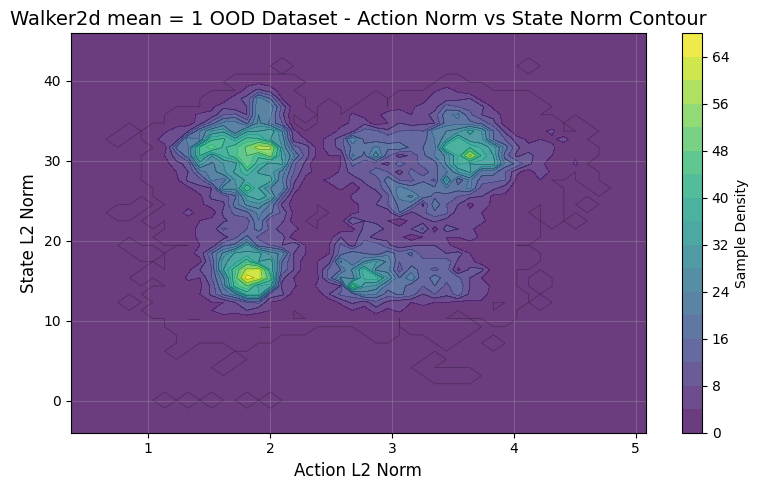

In [96]:
# plot_contour_action_norm_vs_reward(
#         normal, 
#         title=f"Walker2d mean = 0.6 OOD Dataset - Action Norm vs State Norm Contour",
#         bins=50,
#         unsafe_region_reward=None,
#         unsafe_region_norm=None,
#         cmap='viridis'
#     )
plot_contour_action_norm_vs_reward(
        combined_04, 
        title=f"Walker2d mean = 0.4 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_06, 
        title=f"Walker2d mean = 0.6 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_08, 
        title=f"Walker2d mean = 0.8 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_1, 
        title=f"Walker2d mean = 1 OOD Dataset - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
# plot_contour_action_norm_vs_reward(
#         combined_2, 
#         title=f"Walker2d mean = 2 OOD Dataset - Action Norm vs State Norm Contour",
#         bins=50,
#         unsafe_region_reward=None,
#         unsafe_region_norm=None,
#         cmap='viridis'
#     )
# plot_contour_action_norm_vs_reward(
#         combined_3, 
#         title=f"Walker2d mean = 3 OOD Dataset - Action Norm vs State Norm Contour",
#         bins=50,
#         unsafe_region_reward=None,
#         unsafe_region_norm=None,
#         cmap='viridis'
#     )
# plot_contour_action_norm_vs_reward(
#         combined_4, 
#         title=f"Walker2d mean = 4 OOD Dataset - Action Norm vs State Contour",
#         bins=50,
#         unsafe_region_reward=None,
#         unsafe_region_norm=None,
#         cmap='viridis'
#     )

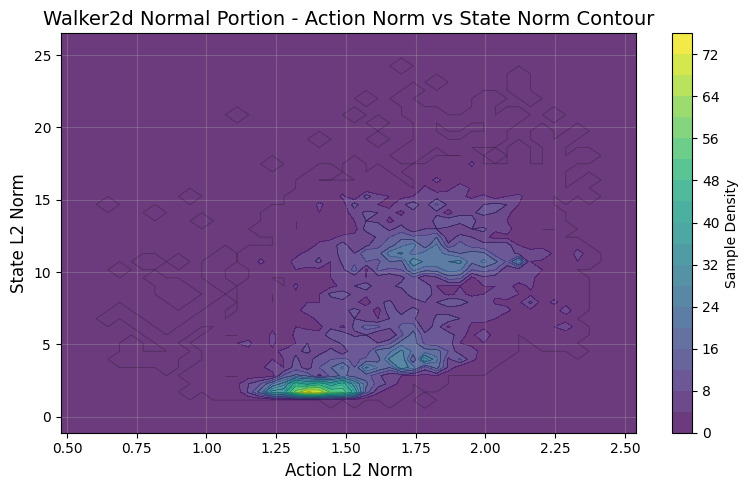

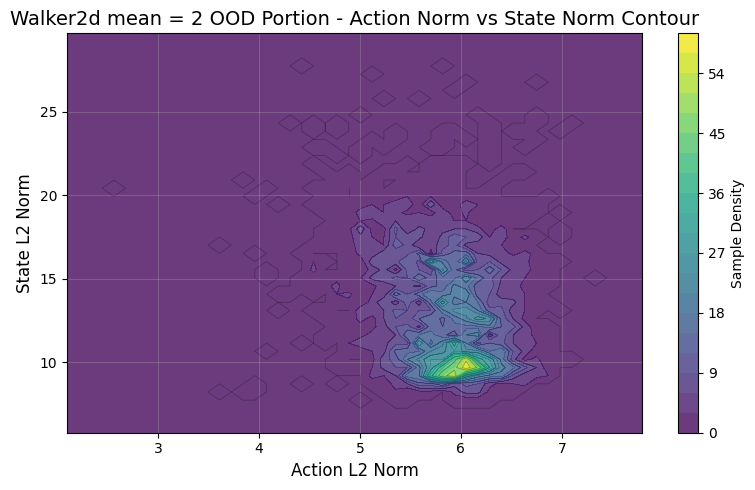

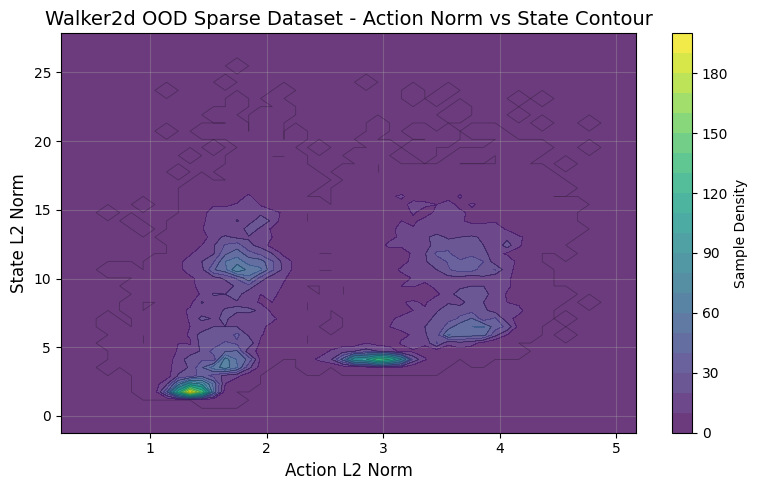

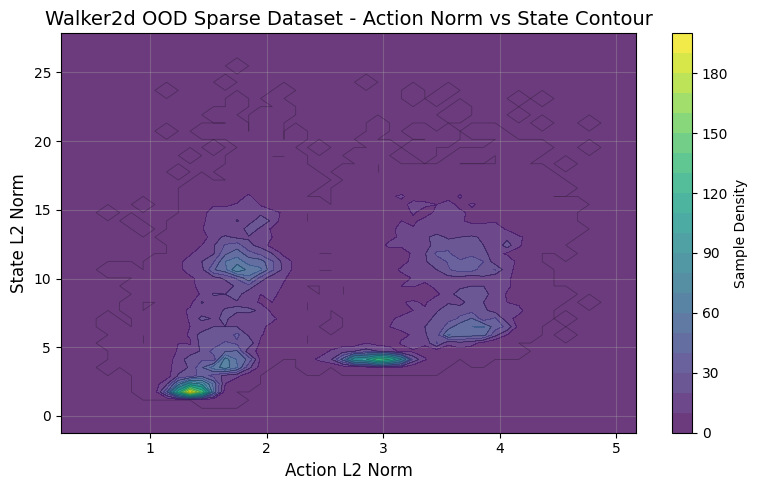

In [41]:


plot_contour_action_norm_vs_reward(
        normal, 
        title=f"Walker2d Normal Portion - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

plot_contour_action_norm_vs_reward(
        ood_data_2, 
        title=f"Walker2d mean = 2 OOD Portion - Action Norm vs State Norm Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_data, 
        title=f"Walker2d OOD Sparse Dataset - Action Norm vs State Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

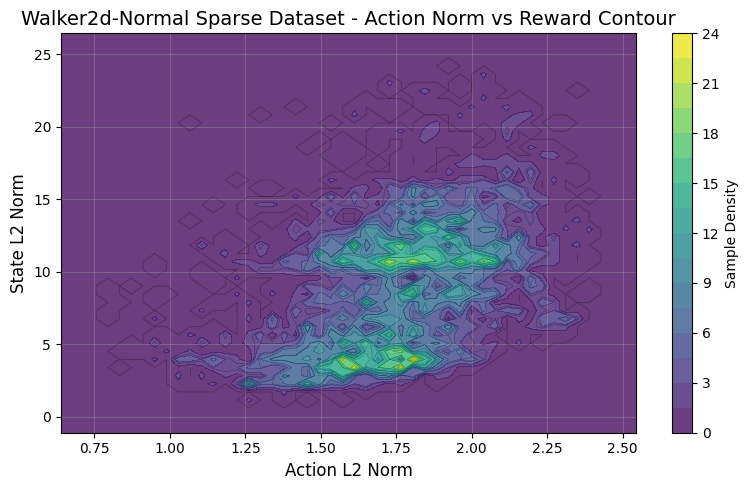

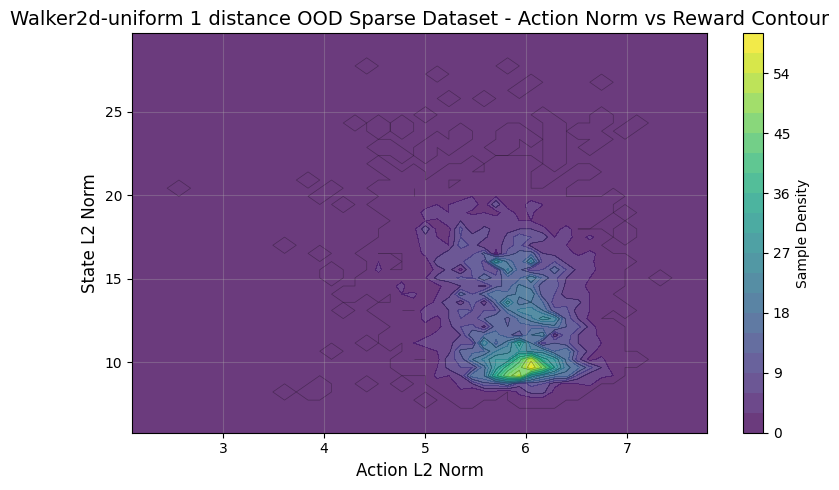

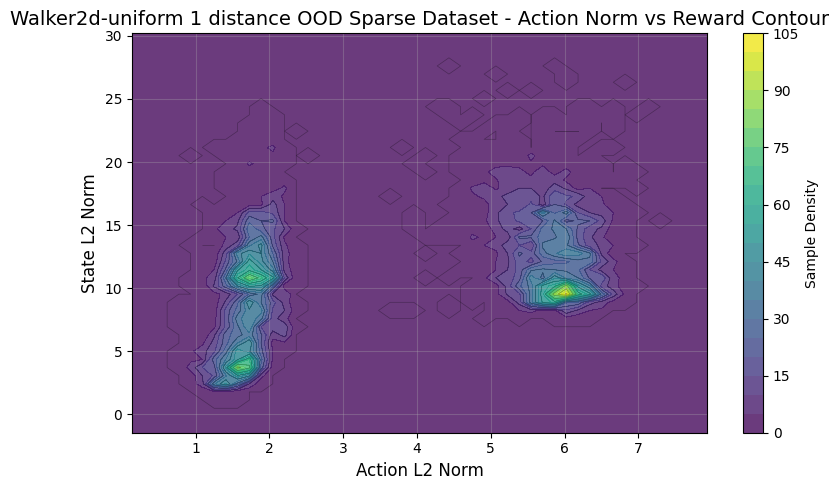

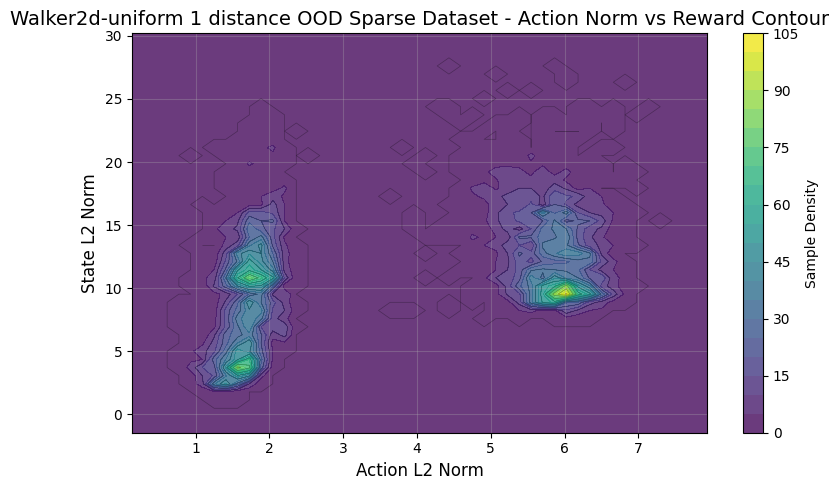

In [37]:
plot_contour_action_norm_vs_reward(
        normal, 
        title=f"Walker2d-Normal Sparse Dataset - Action Norm vs Reward Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

plot_contour_action_norm_vs_reward(
        ood_data_2, 
        title=f"Walker2d-uniform 1 distance OOD Sparse Dataset - Action Norm vs Reward Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_data, 
        title=f"Walker2d-uniform 1 distance OOD Sparse Dataset - Action Norm vs Reward Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

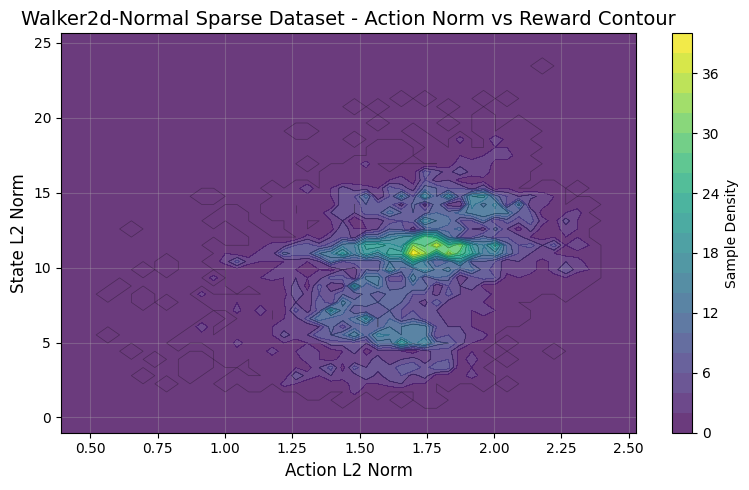

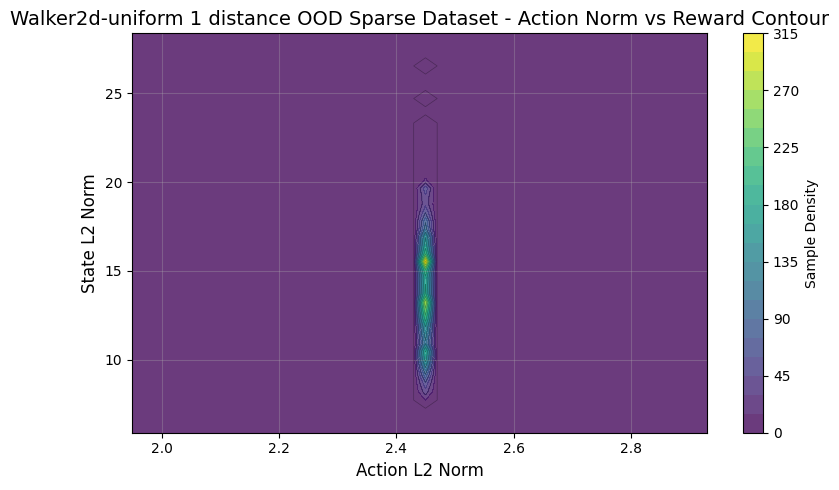

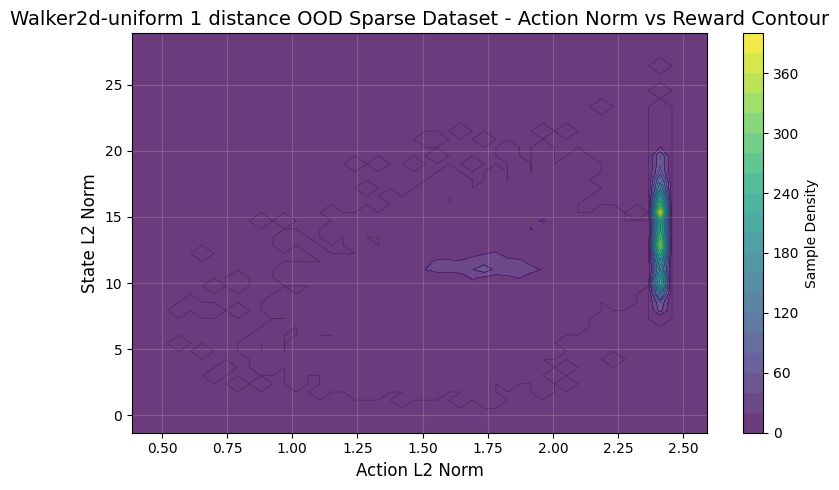

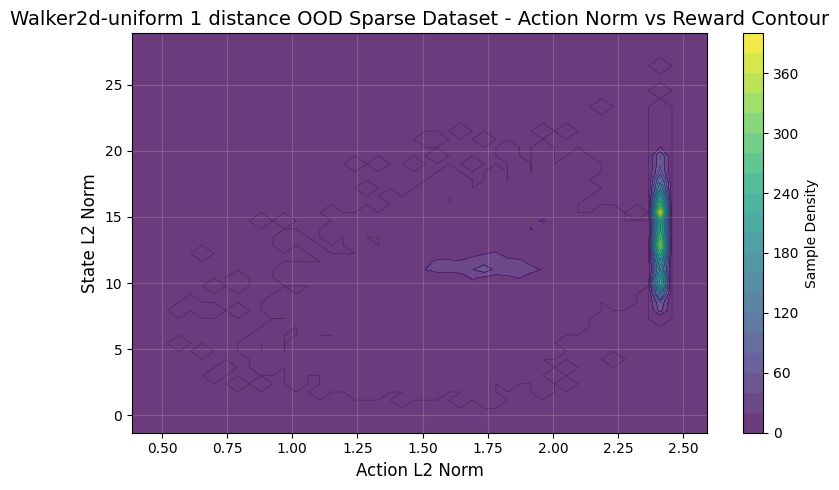

In [21]:
plot_contour_action_norm_vs_reward(
        normal, 
        title=f"Walker2d-Normal Sparse Dataset - Action Norm vs Reward Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )

plot_contour_action_norm_vs_reward(
        ood_data_2, 
        title=f"Walker2d-uniform 1 distance OOD Sparse Dataset - Action Norm vs Reward Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
plot_contour_action_norm_vs_reward(
        combined_data, 
        title=f"Walker2d-uniform 1 distance OOD Sparse Dataset - Action Norm vs Reward Contour",
        bins=50,
        unsafe_region_reward=None,
        unsafe_region_norm=None,
        cmap='viridis'
    )
# plot_contour_action_norm_vs_reward(
#         ood_data_5, 
#         title=f"Walker2d-uniform 5 distance OOD Sparse Dataset - Action Norm vs Reward Contour",
#         bins=50,
#         unsafe_region_reward=None,
#         unsafe_region_norm=None,
#         cmap='viridis'
#     )

In [14]:
ood_data_5, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
ood_data_10, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean =2)
ood_data_15, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 3)
ood_data_20, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 4)
# ood_data_20, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)

# # ood_data_07, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
save_combined_dataset(normal, ood_data_5, 'walker2d-medium-expert-v2' , 1)
save_combined_dataset(normal, ood_data_10, 'walker2d-medium-expert-v2', 2)
save_combined_dataset(normal, ood_data_15, 'walker2d-medium-expert-v2', 3)
save_combined_dataset(normal, ood_data_20,'walker2d-medium-expert-v2', 4)
# save_combined_dataset(normal, ood_data_20,'walker2d-medium-v2', 1)

In [10]:
ood_data_5, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
ood_data_10, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean =2)
ood_data_15, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 3)
ood_data_20, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 4)

# ood_data_07, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
save_combined_dataset(normal, ood_data_5, 'hopper-medium-expert-v2' , 1)
save_combined_dataset(normal, ood_data_10, 'hopper-medium-expert-v2', 2)
save_combined_dataset(normal, ood_data_15, 'hopper-medium-expert-v2', 3)
save_combined_dataset(normal, ood_data_20,'hopper-medium-expert-v2', 4)
# save_combined_dataset(normal, ood_data_07,'hopper-medium-expert-v2', 1)

In [13]:
ood_data_01, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
ood_data_03, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 2)
ood_data_05, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 3)
ood_data_07, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 4)
# ood_data_1, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)


save_combined_dataset(normal, ood_data_01, 'halfcheetah-medium-expert-v2' , 1)
save_combined_dataset(normal, ood_data_03, 'halfcheetah-medium-expert-v2', 2)
save_combined_dataset(normal, ood_data_05, 'halfcheetah-medium-expert-v2', 3)
save_combined_dataset(normal, ood_data_07, 'halfcheetah-medium-expert-v2', 4)

# save_combined_dataset(normal, ood_data_1,'halfcheetah-medium-v2', 1)

In [10]:
ood_data_01, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.1)
ood_data_03, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.3)
ood_data_05, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.5)
ood_data_09, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 0.9)

ood_data_1, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 1)
ood_data_5, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 5)
ood_data_10, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 10)
ood_data_15, normal = select_subset_and_add_noise(ha_dataset, num_trajectories=5, noise_std=0.1, noise_mean = 15)

save_combined_dataset(normal, ood_data_01, 'halfcheetah-medium-expert-v2' , 0.1)
save_combined_dataset(normal, ood_data_03, 'halfcheetah-medium-expert-v2' , 0.3)
save_combined_dataset(normal, ood_data_05, 'halfcheetah-medium-expert-v2', 0.5)
save_combined_dataset(normal, ood_data_09, 'halfcheetah-medium-expert-v2', 0.9)

save_combined_dataset(normal, ood_data_1, 'halfcheetah-medium-expert-v2' , 1)
save_combined_dataset(normal, ood_data_5, 'halfcheetah-medium-expert-v2' , 5)
save_combined_dataset(normal, ood_data_10, 'halfcheetah-medium-expert-v2', 10)
save_combined_dataset(normal, ood_data_15, 'halfcheetah-medium-expert-v2', 15)

In [49]:
ood_data_5, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 5)
ood_data_10, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 10)
ood_data_15, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 15)
ood_data_20, normal = select_subset_and_add_noise(ho_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 20)

save_combined_dataset(normal, ood_data_5, 'hopper-medium-v2,' , 5)
save_combined_dataset(normal, ood_data_10, 'hopper-medium-v2', 10)
save_combined_dataset(normal, ood_data_15, 'hopper-medium-v2', 15)
save_combined_dataset(normal, ood_data_20,'hopper-medium-v2', 20)

In [14]:
ood_data, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 5)

In [23]:
ood_data_10=ood_data

In [24]:
ood_data_5, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 5)

In [30]:
ood_data_15, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 15)

In [34]:
ood_data_20, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 20)

In [36]:
ood_data_40, normal = select_subset_and_add_noise(wa_dataset, num_trajectories=10, noise_std=0.1, noise_mean = 40)

In [14]:
#reduce the dimension of the action space with PCA
from sklearn.decomposition import PCA
class PCAReduction:
    def __init__(self, n_components):
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, data):
        self.pca.fit(data)
        self.fitted = True

    def transform(self, data):
        if not self.fitted:
            raise RuntimeError("PCA model is not fitted yet.")
        return self.pca.transform(data)

    def inverse_transform(self, data):
        if not self.fitted:
            raise RuntimeError("PCA model is not fitted yet.")
        return self.pca.inverse_transform(data)

In [10]:
def reduce_and_plot(env_name,limits = [-7, 0]):   

    env = gym.make(env_name)
    dataset = env.get_dataset() 
    pca_reducer = PCAReduction(n_components=1)
    pca_reducer.fit(dataset['actions'])
    pca_reducer_obs = PCAReduction(n_components=1)

    pca_reducer_obs.fit(dataset['observations'])

    # Transform the actions in the dataset
    reduced_actions = pca_reducer.transform(dataset['actions'])
    reduced_obs = pca_reducer_obs.transform(dataset['observations'])
    # plot the actions versus the rewards
    import matplotlib.pyplot as plt
    plt.scatter(reduced_actions, reduced_obs, c= dataset['rewards'], cmap='viridis')
    plt.colorbar(label='Rewards')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('State-Action Space Colored by Rewards')
    plt.show()

    #take out 90% of the states < -7 and actions less than 0 in the reduced space
    indices_to_keep = []
    for i in range(len(reduced_obs)):
        if reduced_obs[i, 0] < limits[0] and reduced_actions[i, 0] < limits[1]:
            if random.random() > 0.99:
                indices_to_keep.append(i)
        else:
            indices_to_keep.append(i)
    filtered_obs = reduced_obs[indices_to_keep]
    filtered_actions = reduced_actions[indices_to_keep]
    filtered_rewards = dataset['rewards'][indices_to_keep]
    # filtered_next_obs = dataset['next_observations'][indices_to_keep]
    # filtered_dones = dataset['terminals'][indices_to_keep]
    print(f"Original dataset size: {len(dataset['observations'])}")
    import matplotlib.pyplot as plt
    plt.scatter(filtered_actions, filtered_obs, c= filtered_rewards, cmap='viridis')
    plt.colorbar(label='Rewards')
    #horizontal and vertical lines at x=0 and y=-7
    plt.axhline(y=filtered_obs.min(), color='r', linestyle='--')
    plt.axvline(x=filtered_actions.min(), color='r', linestyle='--')
    plt.axhline(y=filtered_obs.max(), color='r', linestyle='--')
    plt.axvline(x=filtered_actions.max(), color='r', linestyle='--')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.title('State-Action Space Colored by Rewards')
    plt.show()

    print(len(filtered_obs))

    filtered_dataset = {
    'observations': dataset['observations'][indices_to_keep],
    'actions': dataset['actions'][indices_to_keep],
    'rewards': dataset['rewards'][indices_to_keep],
    'next_observations': dataset['next_observations'][indices_to_keep],
    'terminals': dataset['terminals'][indices_to_keep]
        }
    return filtered_dataset


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:46: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum act

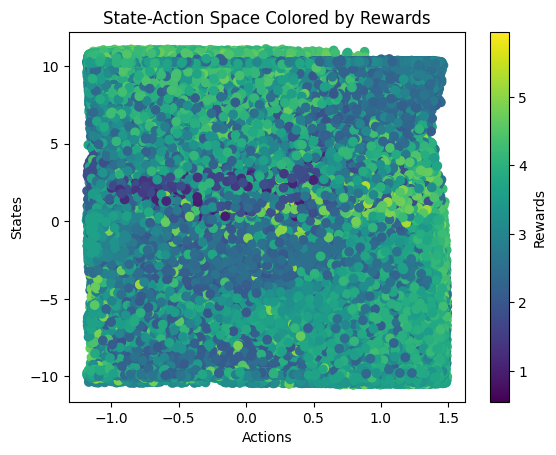

Original dataset size: 1000000


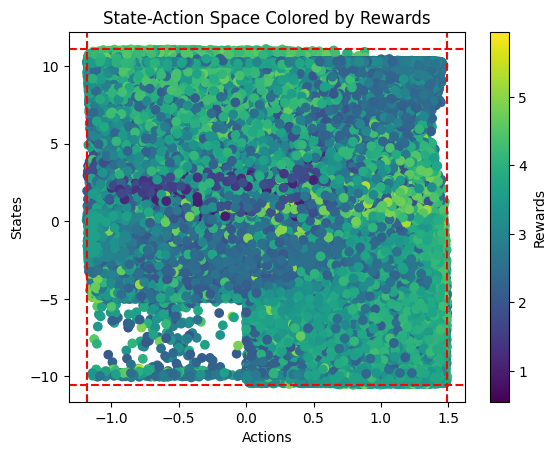

966248


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:46: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum act

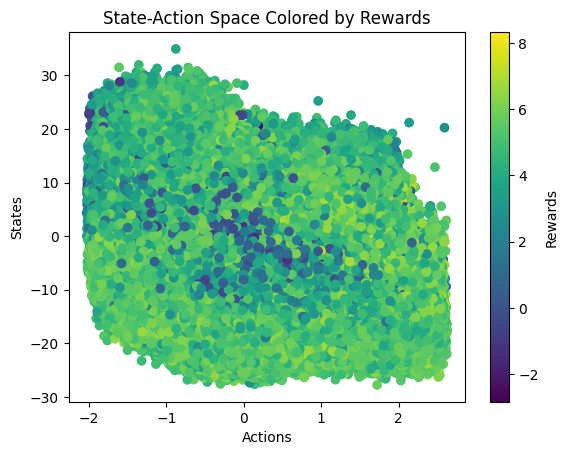

Original dataset size: 1000000


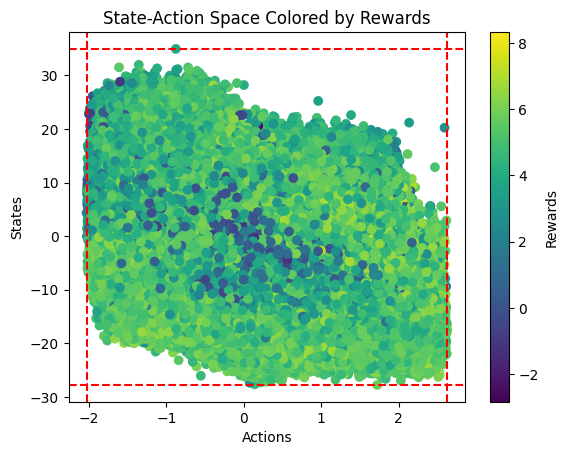

970610


/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/envs/mujoco/mujoco_env.py:46: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ubuntu/miniconda3/envs/mopo/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum act

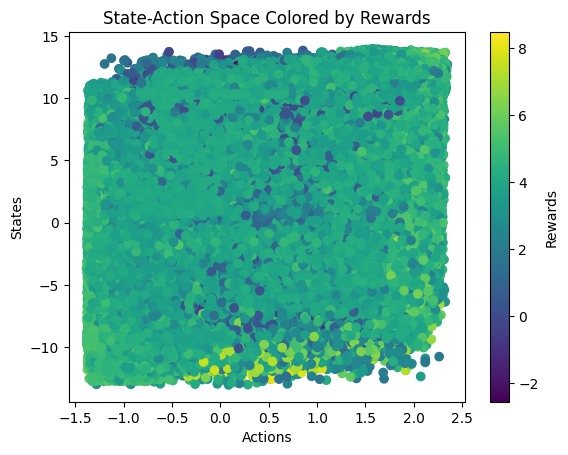

Original dataset size: 1000000


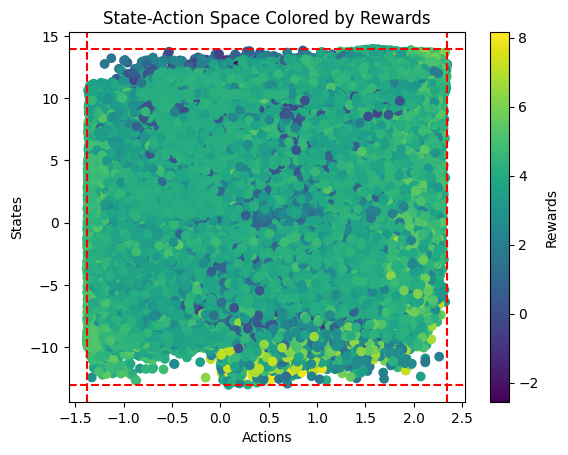

972494


In [34]:
hopper_d = reduce_and_plot('hopper-medium-v2', limits= [-5, 0])
halfcheetah_d = reduce_and_plot('halfcheetah-medium-v2', limits = [-20, 0])
walker2d_d  = reduce_and_plot('walker2d-medium-v2', limits = [-10, 0])


import pickle
with open('../../public/sparse_d4rl/hopper-medium-v2.pkl', 'wb') as f:
    pickle.dump(hopper_d, f)
with open('../../public/sparse_d4rl/halfcheetah-medium-v2.pkl', 'wb') as f:
    pickle.dump(halfcheetah_d, f)
with open('../../public/sparse_d4rl/walker2d-medium-v2.pkl', 'wb') as f:
    pickle.dump(walker2d_d, f)